# Methods for estimating the power spectral density (PSD) of a time-domain signal

Description: The Power Spectral Density (PSD) of a time-domain signal represents the signal power in the frequency domain.
That is, the PSD shows which frequency content within a signal are strong relative to other frequency content. Generally, the PSD is computed using the Fast Fourier Transform (FFT), an efficient algorithm for computing the Discrete Fourier transform (DFT) of a sequence or signal. However, other methods are available (via `scipy`) that provide improved signal-to-noise (SNR). 

Here is a basic script for calculating the PSD of a time-domain signal using different methods. Please note that these methods all employ a FFT (The Fast Fourier Transform), an efficient algorithm for computing the Discrete Fourier Transform (DFT). 

I will try to provide a more thorough explanation of FFT and DFT computations as well as normalization and compensation for discretization of these signals. However, for now we can consider a continuous signal $x(t)$ acquired in the time domain.  The frequency contents of this signal can be represented by its Fourier transform $X(f)$, where 

$X(f) = \int_{t_0}^{t_f}x(t)e^{-i2\pi f t}dt$  





# Required packages (scipy, numpy, and matplotlib):

The scipy package offers various methods for calculating the PSD in addition to the straight forward FFT offered in `numpy`. The periodogram method is a one method as well as Welch’s method. Welch's improves upon the periodogram method by reducing noise in exchange for reducing the frequency resolution.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np
import math

First, lets define a function nextpow2 that for a given number x will find its next power of 2. This will be used for zero-padding FFTs later. 

In [2]:
def nextpow2(x):
    ''' 
    calculate the next power of 2 of x
    '''
    return (x-1).bit_length()

# Time-Domain Signal $y(t)$

Lets define a time-domain signal, with $y_{noise}(t)$ and without $y(t)$ zero-sum noise, that we will later be processing. 

The principal frequency component ($f_0$; units of Hz) of the signal can be defined along with its amplitude below. 

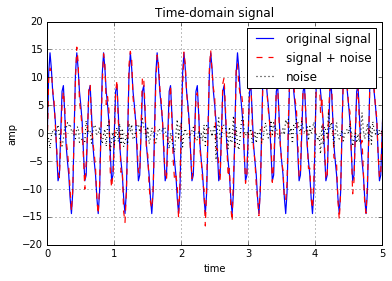

In [3]:
'''
time signal calculation (w\ and w\o noise)
'''
# INPUT parameter
f0 = 5;    # center freq of primary component of signal
amp = 10;  # amplitude of primary component

# calcualted paramters
Fs = 10*f0 # sampling frequency 
t = np.arange(0,float(10*f0/2),float(1/Fs))# time vector

# non noisey sigal y 
y = amp*np.sin(2 * np.pi * f0 * t)         # primary component
y = amp/2*np.sin(2 * np.pi * f0/2 * t) + y # spectral component 1
y = amp/3*np.sin(2 * np.pi * f0*2 * t) + y # spectral component 2

# add noise to signal ynoise
noise = np.random.normal(0,1.5,len(t)) # noise
ynoise = y + noise # signal plus noise

# plot on log scale --------------------
plt.plot(t, y,'b-',linewidth=1.2, label='original signal')
plt.plot(t, ynoise,'r--',linewidth=1.2, label='signal + noise')
plt.plot(t, noise,'k:',linewidth=1.2, label='noise')
plt.xlabel('time')
plt.ylabel('amp')
plt.title('Time-domain signal')
plt.legend(loc='upper right')
plt.xlim([0,5])
plt.grid()
plt.show()

# FFT and frequency-domain representation Y(f): 

First, we can take the FFT of the signal. For this example, the the FFT of the noisey signal is zero-padded to the next power of 2 of the length of the original signal. 

Since we are extending the number of points within the sample that is zero padded, but not at an increased rate (fs), seperate frequency vectors need to be defined for the zero-padded and non-zero padded signals. 

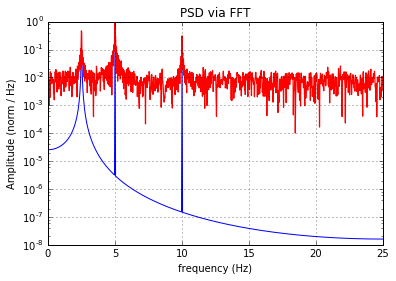

In [4]:
''' 
frequency spectrum using FFT
'''
freq  = np.linspace(0,Fs,len(t)) # freq vec for non-zero pad signal
freqn = np.linspace(0,Fs, 2**nextpow2(len(ynoise)))# freq vector for zero pad signal

# fft of non-noisey signal---------------
Y = np.fft.fft(y) # fft of y (non-noisey signal)
Y = np.abs(Y)**2  # square the abs value of Y
Y = (Y/max(Y))    # normalize to max val

# fft of noisey signal---------------
Y2 = np.fft.fft(ynoise,2**nextpow2(len(ynoise))) # fft with zero padding to length Nzero
Y2 = np.abs(Y2) 
Y2 = Y2/max(Y2) # normalize to max val

# plot on log scale --------------------
plt.semilogy(freq, Y, 'b-')
plt.semilogy(freqn, Y2, 'r-',linewidth=1.2)
plt.ylabel('Amplitude (norm / Hz)')
plt.xlabel('frequency (Hz)')
plt.title('PSD via FFT')
plt.xlim([0,Fs/2])
plt.grid()
plt.show()


# Method of periodograms

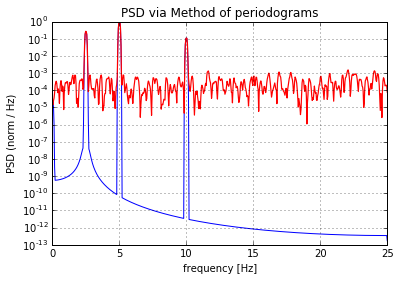

In [5]:
'''
Frequency spectrum using method of periodograms
'''
# signal w\o noise ---------------
fp, Pper_spec = signal.periodogram(y, Fs, 'flattop', scaling='spectrum')
Pper_spec = Pper_spec/max(Pper_spec) # normalize re max
# signal w\ noise ---------------
fp, Pper_spec2 = signal.periodogram(ynoise, Fs, 'flattop', scaling='spectrum')
Pper_spec2 = Pper_spec2/max(Pper_spec2) # normalize re max
# plot on log scale --------------------
plt.semilogy(fp, Pper_spec,'b-')
plt.semilogy(fp, Pper_spec2,'r-',linewidth=1.2)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD (norm / Hz)')
plt.title('PSD via Method of periodograms')
plt.grid()
plt.show()

# Welchs method

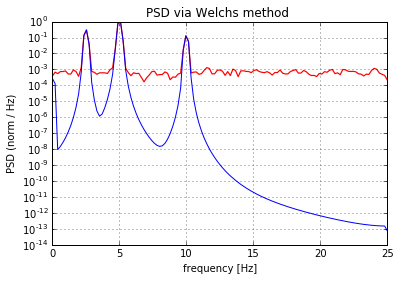

In [6]:
'''
Frequency spectrum using Welch's method
'''
# signal w\ noise
fw, Pwelch_spec2 = signal.welch(ynoise, Fs, scaling='spectrum')
Pwelch_spec2 = Pwelch_spec2/max(Pwelch_spec2)
# signal w\o noise
fw, Pwelch_spec = signal.welch(y, Fs, scaling='spectrum')
Pwelch_spec = Pwelch_spec/max(Pwelch_spec)
# plot on log scale --------------------
plt.semilogy(fw, Pwelch_spec2/max(Pwelch_spec2),'r-',linewidth=1.2)
plt.semilogy(fw, Pwelch_spec/max(Pwelch_spec)  ,'b-')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD (norm / Hz)')
plt.title('PSD via Welchs method ')
plt.grid()
plt.show()

# Comparison of methods:

### Frequency spectra of signal absent of noise. 

Shown below are the various PSD estimation methods for the sample signal wihtout noise. Notably, each methods produces equivalent peak amplitudes. However, relative noise floor for each are drasticly different. 

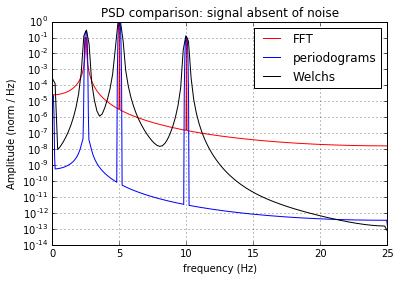

In [7]:
plt.semilogy(freq, Y, 'r-',      label='FFT')
plt.semilogy(fp, Pper_spec,'b-', label= 'periodograms')
plt.semilogy(fw, Pwelch_spec/max(Pwelch_spec)  ,'k-', label='Welchs')
plt.ylabel('Amplitude (norm / Hz)')
plt.xlabel('frequency (Hz)')
plt.title('PSD comparison: signal absent of noise')
plt.legend(loc='upper right')
plt.xlim([0,Fs/2])
plt.grid()



### Frequency spectra of signal with noise. 

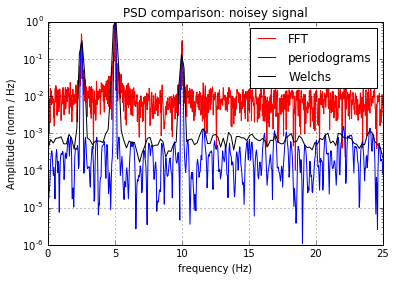

In [8]:
plt.semilogy(freqn, Y2, 'r-', label='FFT')
plt.semilogy(fp, Pper_spec2,'b-',label= 'periodograms')
plt.semilogy(fw, Pwelch_spec2/max(Pwelch_spec)  ,'k-',label= 'Welchs')
plt.ylabel('Amplitude (norm / Hz)')
plt.xlabel('frequency (Hz)')
plt.title('PSD comparison: noisey signal')
plt.legend(loc='upper right')
plt.xlim([0,Fs/2])
plt.grid()